In [19]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils
from Utils import plot_utils
from Utils import common_functions
importlib.reload(plot_utils)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [2]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

In [3]:
before_dismissed = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
                    1327, 1451, 1477, 1482, 2003]

15 5 533 (552, 3600) (19, 3600) True
15 10 506 (552, 3600) (46, 3600) True
15 20 427 (552, 3600) (125, 3600) True
15 30 349 (552, 3600) (203, 3600) True
20 5 535 (552, 4800) (17, 4800) True
20 10 501 (552, 4800) (51, 4800) True
20 20 412 (552, 4800) (140, 4800) True
20 30 328 (552, 4800) (224, 4800) True
30 5 539 (552, 7200) (13, 7200) True
30 10 499 (552, 7200) (53, 7200) True
30 20 401 (552, 7200) (151, 7200) True
30 30 295 (552, 7200) (257, 7200) True


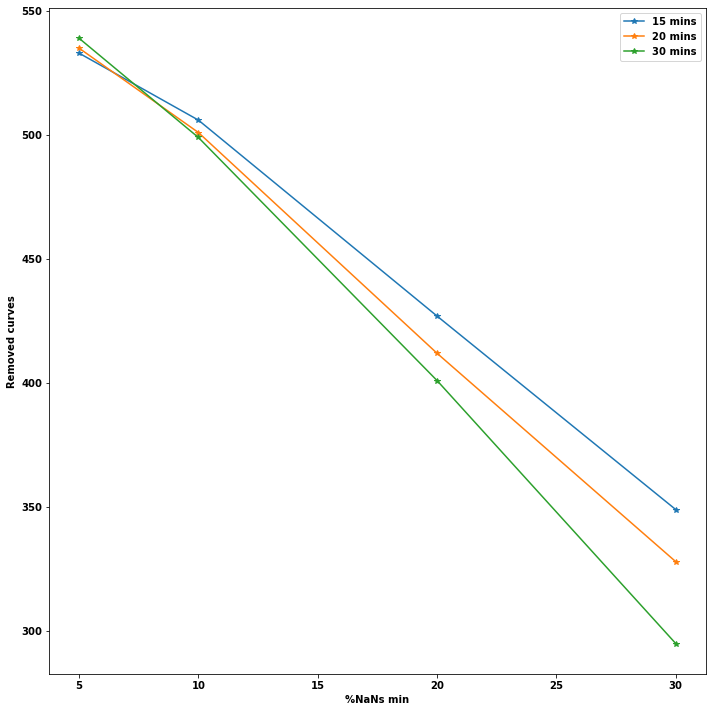

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nan_percentage_thresholds = [5, 10, 20, 30]
for mins_cut in [15, 20, 30]:
    results = []
    for nan_percentage_threshold in nan_percentage_thresholds:
        cut_fhr = fhr.copy().iloc[:, -mins_cut * 60 * 4:]
        fhr_nans_percent = (cut_fhr.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
        fhr_now_dismissed = fhr_nans_percent.index[fhr_nans_percent > nan_percentage_threshold].to_list()

        cut_uc = uc.copy().iloc[:, -mins_cut * 60 * 4:]
        uc_nans_percent = (cut_uc.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
        uc_now_dismissed = uc_nans_percent.index[uc_nans_percent > nan_percentage_threshold].to_list()

        removed = list(set(fhr_now_dismissed).union(set(uc_now_dismissed)))

        check_list = [x for x in before_dismissed if (x not in fhr_now_dismissed) and (x not in uc_now_dismissed)]
        print(
            f"{mins_cut} {nan_percentage_threshold} {len(removed)} {cut_fhr.shape} {cut_fhr.drop(removed).shape} {len(check_list) == 0}")
        results.append(len(removed))
    ax.plot(nan_percentage_thresholds, results, '*-', label=f"{mins_cut} mins")
ax.legend()
ax.set_ylabel('Removed curves')
ax.set_xlabel('%NaNs min')
# ax.set_yscale('log')
fig.tight_layout()
plt.savefig(f"filtered_curves.pdf")

In [5]:
mins_cuts = 30
nan_percentage_threshold = 30
clean_fhr, clean_uc, y_clean = common_functions.filter_patterns(
    fhr, uc, y,
    mins_cut=mins_cut, nan_percentage_threshold=nan_percentage_threshold)

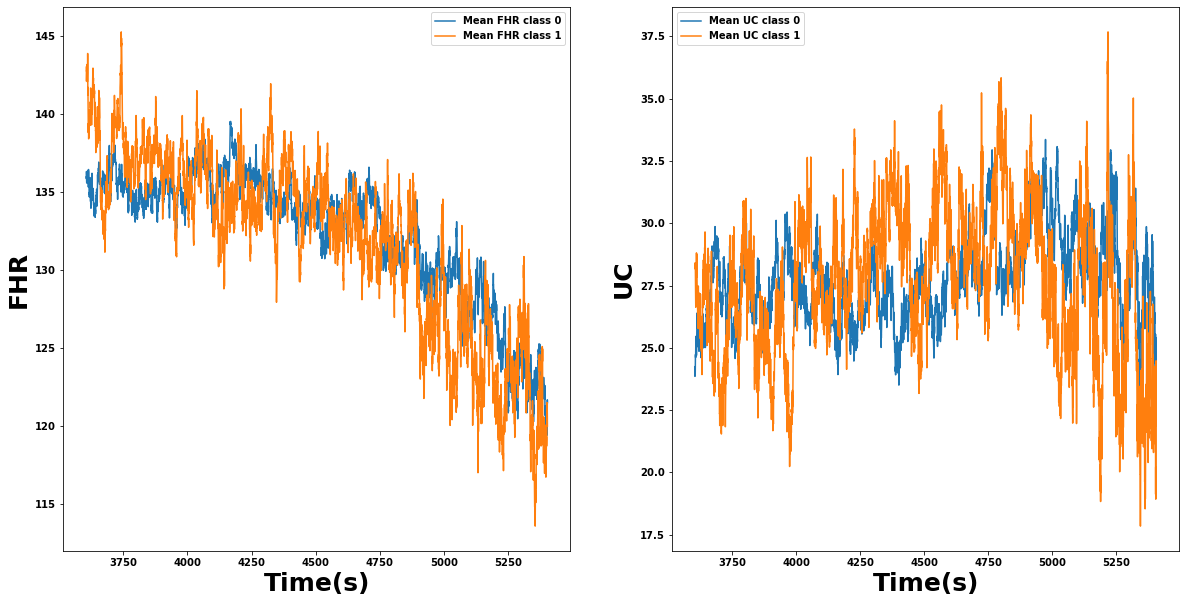

In [6]:
plot_utils.plot_fhr_uc(clean_fhr, clean_uc, y_clean)

In [7]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 1000) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/257 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1008,-0.027218,-0.027350,-0.027450,-0.027376,-0.027243,-0.026799,-0.026282,-0.025606,-0.024953,-0.024232,...,-0.447103,-0.446072,-0.444980,-0.444201,-0.443296,-0.442431,-0.441648,-0.440916,-0.440144,-0.439561
1011,-0.031679,-0.032592,-0.033147,-0.033720,-0.033770,-0.033200,-0.031955,-0.030639,-0.029292,-0.027882,...,-0.097333,-0.094022,-0.090596,-0.087206,-0.083688,-0.080219,-0.076717,-0.073410,-0.070142,-0.067485
1012,-0.081252,-0.082587,-0.083860,-0.084978,-0.086131,-0.087201,-0.088620,-0.090377,-0.092559,-0.094490,...,-0.106782,-0.107614,-0.108310,-0.109056,-0.110060,-0.110531,-0.111074,-0.111211,-0.111114,-0.110515
1018,0.147230,0.147562,0.148149,0.149600,0.150158,0.151066,0.151505,0.152044,0.152471,0.152992,...,-0.139580,-0.139952,-0.140761,-0.141679,-0.142533,-0.143845,-0.145525,-0.147182,-0.148347,-0.150240
1020,-0.054537,-0.057466,-0.060471,-0.063406,-0.066573,-0.069506,-0.072400,-0.075397,-0.078185,-0.081130,...,-0.009317,-0.010331,-0.010540,-0.009947,-0.010436,-0.010994,-0.012442,-0.014626,-0.015909,-0.017865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,0.112279,0.108199,0.104078,0.099634,0.095342,0.091268,0.087211,0.082954,0.078658,0.074261,...,-0.013257,-0.014824,-0.016330,-0.017793,-0.019227,-0.020628,-0.021961,-0.023201,-0.024357,-0.025430
2042,-0.000738,0.002091,0.004137,0.006256,0.008269,0.009779,0.012041,0.013751,0.016146,0.017815,...,-0.160555,-0.162530,-0.164358,-0.165887,-0.167516,-0.169220,-0.170950,-0.172518,-0.174011,-0.175446
2043,0.123914,0.121661,0.118638,0.115165,0.111689,0.108751,0.105708,0.102952,0.098659,0.095087,...,-0.142478,-0.142444,-0.142659,-0.143299,-0.142871,-0.142850,-0.142266,-0.142161,-0.141798,-0.141701
2044,-0.022633,-0.022700,-0.023905,-0.024814,-0.026762,-0.027899,-0.028969,-0.030256,-0.031453,-0.032864,...,0.041772,0.043260,0.044041,0.045306,0.045280,0.044637,0.043725,0.042310,0.041209,0.040715


In [8]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [9]:
cc_df = cc_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cc_df.shape, y_clean.shape

((257, 2399), (257,))

In [10]:
cdcor_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cdcor_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 1000)
        for lag in lags
    )
cdcor_df = pd.DataFrame(cdcor_data).T
cdcor_df.columns = lags
cdcor_df

  0%|          | 0/257 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1008,0.158583,0.157925,0.157261,0.156791,0.156391,0.155921,0.155434,0.155124,0.155003,0.155015,...,0.415282,0.414383,0.413427,0.412864,0.412134,0.411359,0.410596,0.410037,0.409526,0.409212
1011,0.175439,0.174031,0.172920,0.171595,0.170653,0.169611,0.168525,0.167550,0.166547,0.165600,...,0.179344,0.178509,0.177679,0.177182,0.176396,0.175586,0.174569,0.173220,0.171720,0.169909
1012,0.171943,0.173155,0.174778,0.176412,0.178082,0.179686,0.181395,0.183594,0.185949,0.188221,...,0.178919,0.179107,0.179561,0.180238,0.181145,0.182179,0.182896,0.183420,0.183846,0.184041
1018,0.219065,0.219615,0.220739,0.222538,0.223570,0.224095,0.224010,0.224175,0.223556,0.223195,...,0.177634,0.177732,0.178016,0.178581,0.179168,0.180244,0.181661,0.183282,0.184606,0.186162
1020,0.135335,0.135715,0.136134,0.136646,0.137463,0.138225,0.139446,0.140480,0.141471,0.142067,...,0.275392,0.274493,0.273918,0.273299,0.272419,0.271579,0.270807,0.270174,0.269833,0.269749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,0.144832,0.141969,0.139045,0.135949,0.132927,0.129998,0.127112,0.124229,0.121504,0.118919,...,0.199407,0.199599,0.199884,0.200042,0.200055,0.200086,0.200109,0.200227,0.200267,0.200305
2042,0.185154,0.184219,0.183264,0.182220,0.181397,0.180722,0.179992,0.179335,0.178755,0.178349,...,0.192412,0.193278,0.194207,0.194873,0.195678,0.196472,0.197346,0.198144,0.199000,0.199868
2043,0.242970,0.242931,0.242949,0.242333,0.241376,0.241265,0.240593,0.240302,0.240163,0.240129,...,0.237815,0.238341,0.238569,0.239083,0.238764,0.238763,0.238342,0.237836,0.237074,0.236393
2044,0.084845,0.084141,0.083606,0.083118,0.083031,0.083013,0.083056,0.083300,0.083440,0.083727,...,0.112233,0.112996,0.113450,0.114420,0.114318,0.114061,0.113745,0.113257,0.113245,0.113412


In [11]:
bad_idx = cdcor_df.index[cdcor_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [12]:
cdcor_df = cdcor_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cdcor_df.shape, y_clean.shape

((257, 2399), (257,))

In [13]:
fft_data = dict()
freqs = t_utils.get_freqs(fhr.shape[-1])

for idx_fhr, fhr_row in tqdm(clean_fhr.copy().iterrows(), total=len(clean_fhr)):
    fhr_signal = fhr_row.values

    fft_data[idx_fhr] = t_utils.nan_save_fft(fhr_signal, freqs)

  0%|          | 0/257 [00:00<?, ?it/s]

In [17]:
fft_df = pd.DataFrame(fft_data).T
fft_df.columns = freqs
fft_df = fft_df.loc[:, freqs <= 0.1]
fft_df = fft_df.iloc[:, 1:]
freqs = np.array(freqs)[freqs <= 0.1][1:]
fft_df

,0.000185,0.000370,0.000555,0.000740,0.000925,0.001110,0.001295,0.001480,0.001665,0.001850,...,0.098242,0.098427,0.098612,0.098797,0.098982,0.099167,0.099352,0.099537,0.099722,0.099907
1008,14180.960419,51325.214383,11484.349730,43414.327482,34410.891275,14733.664355,24497.858460,28649.118547,16220.518918,19789.377373,...,2710.837501,846.146700,1369.763035,1894.197769,4532.943584,2212.611880,2178.423862,1709.959157,8270.047391,3536.268846
1011,75279.047520,45578.058587,21814.718805,2700.371874,4802.555186,23174.233006,28109.189988,22435.889140,42081.410523,2249.896589,...,1022.964127,800.291572,1467.781071,911.194588,1052.207586,1136.411478,1506.333259,1316.602649,1532.578041,1220.601462
1012,114039.718335,50630.979756,22903.239291,29938.773528,10038.480964,65227.642818,72184.394779,30540.198669,22560.836115,28576.352833,...,1803.473140,4179.246938,1288.491519,3859.585621,5152.277307,2709.213972,4895.814135,3061.600401,1531.283550,3120.880170
1018,148964.837727,107079.078773,129283.227031,37354.894658,26910.453837,84675.649375,63973.921815,68764.990840,45405.014064,56091.702618,...,12311.679948,2320.407875,7559.967673,4215.266737,6640.969598,2107.799054,3200.874212,4483.202687,10477.677629,9363.273907
1020,50071.792521,29319.658150,19753.624607,28981.770006,11195.437060,14451.545976,14410.924213,10627.085357,7019.872163,10247.650442,...,2659.543191,3549.938156,3392.793979,1040.865060,2502.491673,1697.969165,697.864977,1570.109722,1879.746997,988.691698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,17602.239529,8558.066046,9689.847986,5926.887169,4349.268387,5082.443583,5606.634852,7469.052381,7390.124619,10843.011600,...,490.996988,487.267860,745.311878,879.747375,1332.045267,1837.573130,777.712506,2008.676439,811.059920,1652.571328
2042,3918.915246,13981.977229,4589.582008,4012.338609,8025.382201,11981.653508,8634.775785,11110.860857,11151.375186,10214.759286,...,1616.558121,1597.350585,1083.487931,1636.629052,703.884181,2777.111322,2272.017209,1257.391387,919.173841,1297.117740
2043,104399.320043,16802.700651,51880.329392,45547.367577,50124.253834,48607.177585,26355.515839,29742.711782,35119.753596,38566.636698,...,7626.697770,3041.655295,815.485884,4546.825609,5019.786196,1534.944143,3678.038977,3119.523231,891.039502,2600.693792
2044,13841.575993,15073.603790,8572.277023,4476.371441,7273.181852,4463.532058,12327.817408,8550.824883,4888.947078,3085.562843,...,610.528354,1429.445683,1421.870969,173.275236,984.654135,1533.209580,843.496006,642.425541,1331.047842,1185.296598


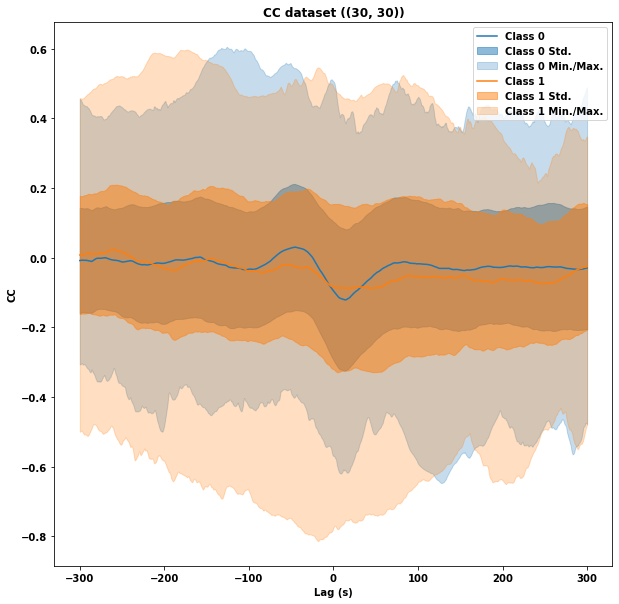

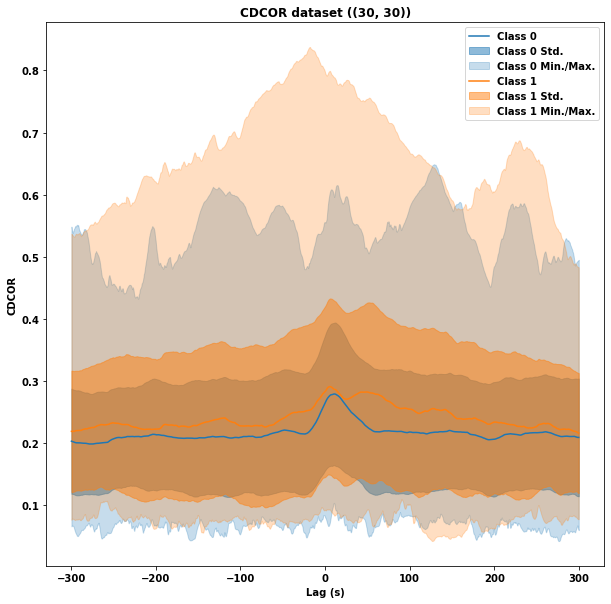

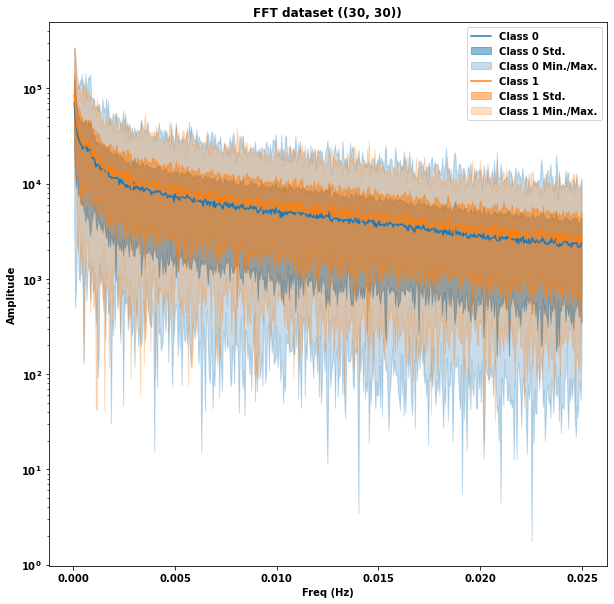

In [20]:
plot_utils.plot_data_desc(tt, cc_df, y_clean, f'CC dataset ({mins_cut, nan_percentage_threshold})', 'CC')
plot_utils.plot_data_desc(tt, cdcor_df, y_clean, f'CDCOR dataset ({mins_cut, nan_percentage_threshold})', 'CDCOR')
plot_utils.plot_data_desc(freqs, fft_df, y_clean, f'FFT dataset ({mins_cut, nan_percentage_threshold})', 'Amplitude', fourier=True)

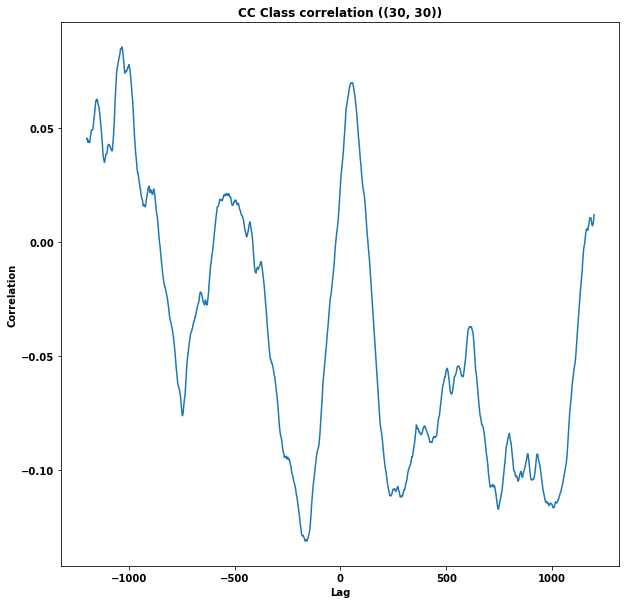

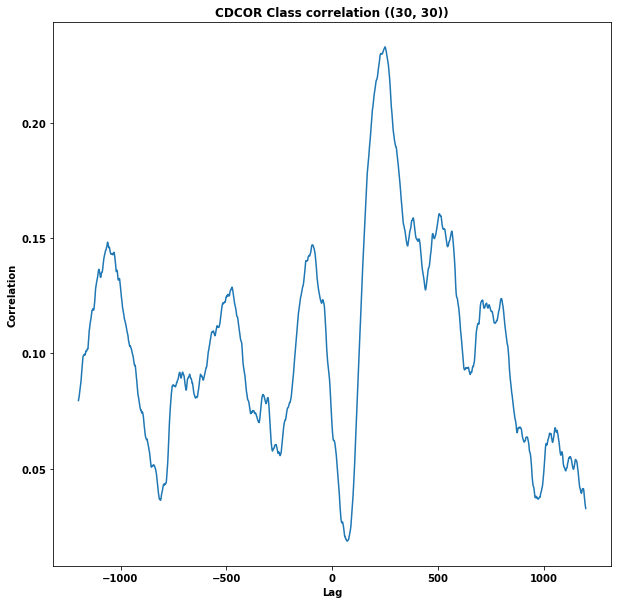

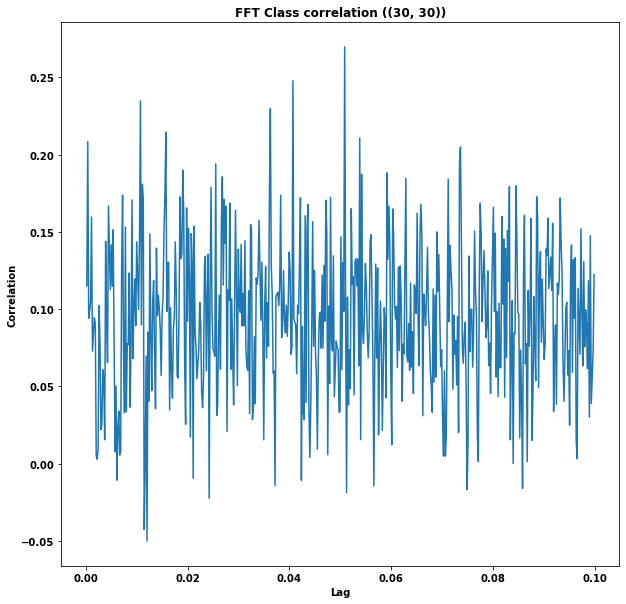

In [21]:
plot_utils.plot_class_correlation(cc_df, y_clean, title=f'CC Class correlation ({mins_cut, nan_percentage_threshold})')
plot_utils.plot_class_correlation(cdcor_df, y_clean, title=f'CDCOR Class correlation ({mins_cut, nan_percentage_threshold})')
plot_utils.plot_class_correlation(fft_df, y_clean, title=f'FFT Class correlation ({mins_cut, nan_percentage_threshold})')

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

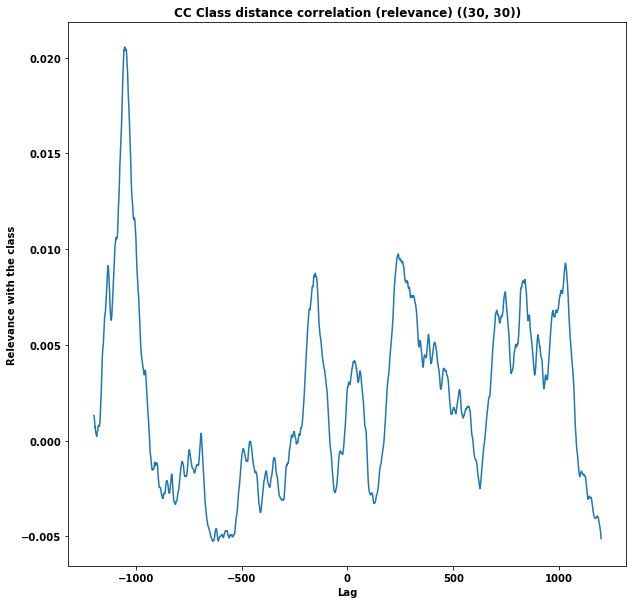

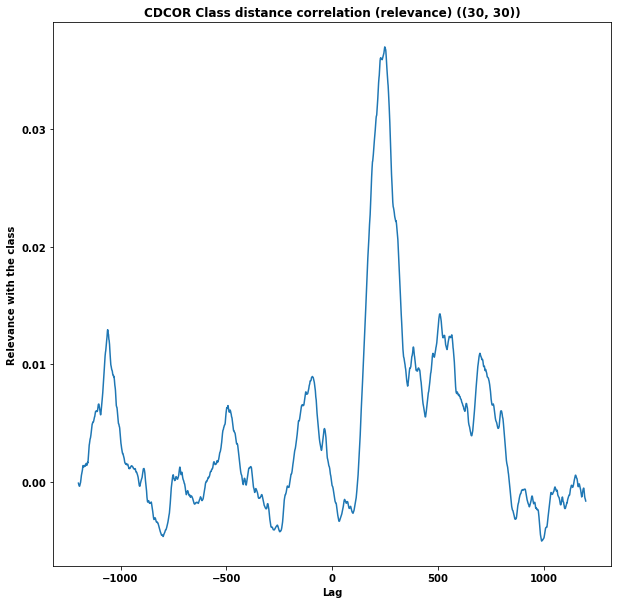

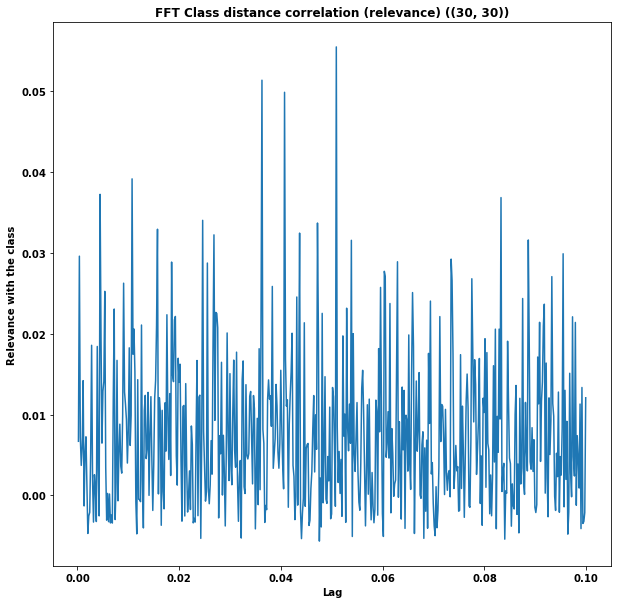

In [22]:
plot_utils.plot_relevance(cc_df, y_clean, title=f'CC Class distance correlation (relevance) ({mins_cut, nan_percentage_threshold})')
plot_utils.plot_relevance(cdcor_df, y_clean, title=f'CDCOR Class distance correlation (relevance) ({mins_cut, nan_percentage_threshold})')
plot_utils.plot_relevance(fft_df, y_clean, title=f'FFT Class distance correlation (relevance) ({mins_cut, nan_percentage_threshold})')

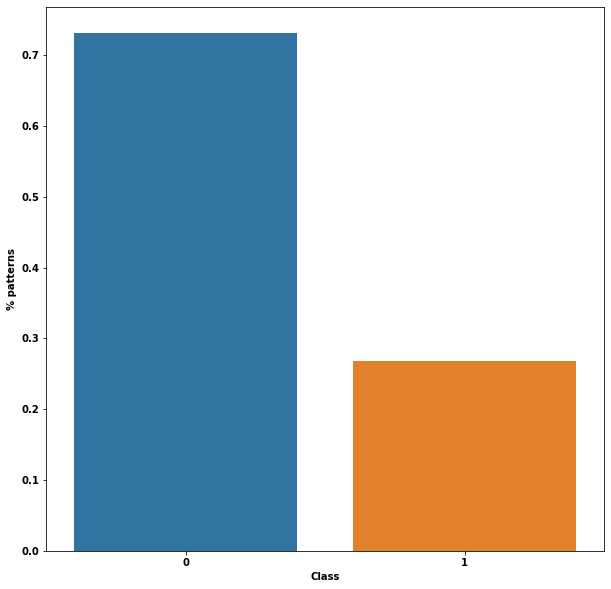

In [23]:
plot_utils.plot_class_proportion(y_clean)